# Baseline model for batch monitoring

In [3]:
import requests
import pandas as pd

from joblib import dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


## Download data

In [7]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-01.parquet: 100%|██████████| 1254291/1254291 [00:12<00:00, 98499.61it/s, save to ./data/green_tripdata_2022-01.parquet] 


## Load data

In [8]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')

In [9]:
jan_data.describe(percentiles=[0.95, 0.99])

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026354,2022-01-16 14:37:37.189551,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
95%,2.000000,2022-01-30 14:16:16.200000,2022-01-30 14:32:46,2.000000,244.000000,260.000000,3.000000,8.463000,35.000000,1.00000,0.500000,5.710000,0.000000,0.300000,41.350000,2.000000,1.000000,2.750000
99%,2.000000,2022-01-31 17:31:33.680000,2022-01-31 17:50:49.660000,5.000000,260.000000,264.000000,6.000000,15.561200,57.500000,3.25000,0.500000,10.000000,6.550000,0.300000,67.010600,2.000000,2.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [11]:
jan_data.shape

(62495, 20)

## Preprocess data

### Create target variable

In [12]:
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

### Filter outliers

In [13]:
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

## Plot

<Axes: >

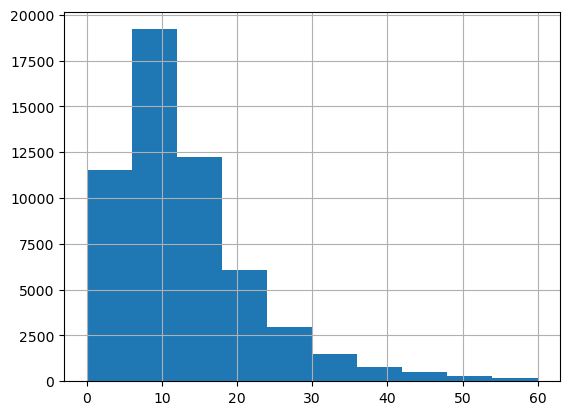

In [14]:
jan_data.duration_min.hist()

## Labeling

In [17]:
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [18]:
jan_data.shape

(55211, 21)

## Split data

In [23]:
train_data = jan_data.sample(frac=0.7, random_state=42)
val_data = jan_data.drop(train_data.index)
train_data.shape, val_data.shape

((38648, 21), (16563, 21))

## Train model

In [24]:
model = LinearRegression()

In [25]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

## Evaluate model

In [27]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [28]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [34]:
train_mae = mean_absolute_error(train_data[target], train_data['prediction'])
val_mae = mean_absolute_error(val_data[target], val_data['prediction'])
print(f"Train MAE: {train_mae:.3f}")
print(f"Val MAE:   {val_mae:.3f}")

Train MAE: 3.921
Val MAE:   3.966


## Dump model and reference data

In [35]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [36]:
val_data.to_parquet('data/reference.parquet')